# Deep Learning Final Project
## Transfer learning-based image classification

Danila Goncharenko, 2303788

Ana Ferreira, 2308587

Mikhail Bichagov, 2304806

Experiments: python=3.9.18, torch=2.1.1, torchvision=0.16.1

###  Students should try their best to improve the classification performance on EuroSAT by using some strategies like data augmentation. (You can follow these steps to complete the project)

i. Download and read the [`miniImageNet`](https://drive.google.com/drive/folders/17a09kkqVivZQFggCw9I_YboJ23tcexNM) & [`EuroSAT(RGB)`](https://github.com/phelber/EuroSAT) datasets. (2 points)

ii. Pretrain a model (ResNet10, also can be ResNet18, VGG, Vision Transformer, etc.) on the training set of miniImageNet, evaluate & test it on the validation & test set. (7 points)

iii. Save the pretrained model. (1 point)

iv. Choose 100 images from EuroSAT dataset, which are from 5 different categories and each category includes 25 samples. You should randomly choose 25 images from these 100 samples as training set (The 25 images should be from the 5 different categories. Each category includes 5 images). (3 points)

v. Fine-tune the pretrained model with these 25 training images and test it on the rest 75 samples, show the results. Better to fine-tuning several times on different 100 EuroSAT images and get their average result. (7 points)

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms

c:\Users\jklbichami\Anaconda3\envs\nlp_course\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# Extracting files from train folder

#import tarfile
#tar_file_path = 'train.tar-20231206T193341Z-001/train.tar'
#
#with tarfile.open(tar_file_path, 'r') as tar:
#    tar.extractall()

In [ ]:
# Extracting files from train google drive folder 
# from google.colab import drive
# drive.mount('/content/gdrive')
# 
# import tarfile
# tar_file_path = '/content/gdrive/MyDrive/train.tar'
# 
# with tarfile.open(tar_file_path, 'r') as tar:
#    tar.extractall()

In [123]:
# Donwloading ResNet18 model
resnet18 = torchvision.models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False

resnet18.fc = nn.Linear(512, 64) # Changign last layer to output 64 featurs


c:\Users\jklbichami\Anaconda3\envs\nlp_course\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jklbichami\Anaconda3\envs\nlp_course\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\jklbichami/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:36<00:00, 1.27MB/s]


In [250]:
# Loading data and splitting it to train, val, test
from torchvision.transforms import v2

transform = v2.Compose([
    v2.Resize((224, 224)), # Resizing to 224x224
    v2.ToTensor(), #moving to tensor
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizing not needed as 
])

dataset = torchvision.datasets.ImageFolder('train', transform=transform) # Loading data from train folder

trainset, valset, testset = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15])

train_data_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

c:\Users\jklbichami\Anaconda3\envs\nlp_course\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


25


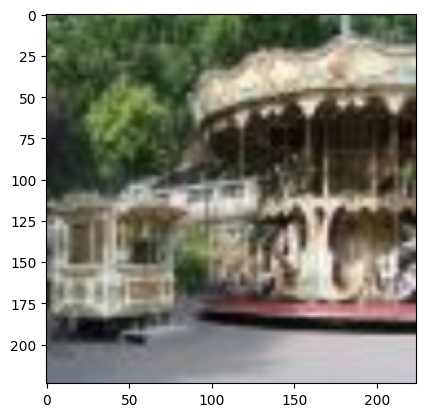

In [258]:
# Get sample immage
import matplotlib.pyplot as plt

images, labels = next(iter(train_data_loader))
plt.imshow(np.transpose(images[1], (1, 2, 0)))
print(labels[1].item())

In [253]:
images[1]

torch.Size([32, 3, 224, 224])

In [170]:
min_pixel_value = torch.min(images[0])
max_pixel_value = torch.max(images[0])
print("Pixel Value Range: [{}, {}]".format(min_pixel_value, max_pixel_value))
mean_value = torch.mean(images[0])
std_deviation = torch.std(images[0])
print("Pixel Value Range: [{}, {}]".format(min_pixel_value, max_pixel_value))

Pixel Value Range: [0.0, 1.0]
Pixel Value Range: [0.0, 1.0]


In [131]:
print(f'total number of images is {32*len(data_loader)}')

total number of images 38400


In [144]:
## Possible GPU acceleration

if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

Using cpu.


In [145]:
## Function to calculate accuracy score

from sklearn.metrics import accuracy_score
def get_acc(y_pred, y_true):
    return accuracy_score(y_true, y_pred)

In [171]:
# Model train with 30 epoch

optimizer = torch.optim.Adam(resnet18.parameters())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18.to(device)

for epoch in range(30):
    bce_loss = nn.CrossEntropyLoss()
    resnet18.train()
    running_train_loss = 0.
    running_val_loss = 0.

    running_train_acc = 0.
    running_val_acc = 0.

    for i, data in enumerate(train_data_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        pred_labels = resnet18.forward(images)

        loss = bce_loss(pred_labels, labels)

        loss.backward()
        optimizer.step()

        running_train_acc += get_acc(torch.argmax(pred_labels, dim = 1).detach().cpu().numpy(), labels.detach().cpu().numpy())
        running_train_loss += loss.item()


    resnet18.eval()
    for i, data in enumerate(val_data_loader):

        images_val, labels_val = data
        images_val, labels_val = images_val.to(device), labels_val.to(device)


        y_pred_labels = resnet18.forward(images_val)
        val_loss = bce_loss(y_pred_labels, labels_val)

        running_val_loss += val_loss
        running_val_acc += get_acc(torch.argmax(y_pred_labels, dim = 1).detach().cpu().numpy(), labels_val.detach().cpu().numpy())

    avg_train_loss = running_train_loss / len(train_data_loader)
    avg_val_loss = running_val_loss / len(val_data_loader)

    avg_train_acc = running_train_acc / len(train_data_loader)
    avg_val_acc = running_val_loss / len(val_data_loader)

    print(f'Epoch {epoch+1} | Training Loss: {avg_train_loss} | Training Accuracy {avg_train_acc}\
                            | Validation loss {avg_val_loss} | Validation Accuracy {avg_val_acc}')

0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.03125
0.0625
0.0625


KeyboardInterrupt: 

In [ ]:
resnet18.eval()

running_test_acc = 0.
running_test_loss = 0.

for i, data in enumerate(test_data_loader):
    images_test, labels_test = data
    images_test, labels_test = images_test.to(device), labels_test.to(device)

    y_pred_labels = resnet18.forward(images_test)
    test_loss = bce_loss(y_pred_labels, labels_test)

    running_test_loss += test_loss
    running_test_acc += get_acc(torch.argmax(y_pred_labels, dim = 1).detach().cpu().numpy(), labels_test.detach().cpu().numpy())
    
    
avg_test_loss = running_test_loss / len(test_data_loader)
avg_test_acc = running_test_acc / len(test_data_loader)

print(f'Test Loss: {avg_test_loss} | Test Accuracy {avg_test_acc}')

In [ ]:
torch.save(resnet18.state_dict(), 'resnet18_model.pt')

In [ ]:
model = ResNet18() # Initialize the model structure
model.load_state_dict(torch.load('resnet18_model.pt'))
model.eval() # Set the model to evaluation mode

In [222]:
from transformers import AutoImageProcessor, ViTModel, ViTFeatureExtractor, ViTForImageClassification

image_processor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", return_dict=False)

vit.classifier = nn.Linear(768,64) # Chaning final output layer to map our problem


c:\Users\jklbichami\Anaconda3\envs\nlp_course\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [181]:
images[0]

tensor([[[0.8431, 0.8431, 0.8353,  ..., 0.7412, 0.7451, 0.7451],
         [0.8431, 0.8431, 0.8353,  ..., 0.7412, 0.7451, 0.7451],
         [0.8353, 0.8353, 0.8314,  ..., 0.7373, 0.7412, 0.7412],
         ...,
         [0.9490, 0.9490, 0.9647,  ..., 0.9765, 0.9765, 0.9765],
         [0.9451, 0.9451, 0.9608,  ..., 0.9765, 0.9765, 0.9765],
         [0.9451, 0.9451, 0.9608,  ..., 0.9765, 0.9765, 0.9765]],

        [[0.8039, 0.8039, 0.7961,  ..., 0.6824, 0.6863, 0.6863],
         [0.8039, 0.8039, 0.7961,  ..., 0.6824, 0.6863, 0.6863],
         [0.7961, 0.7961, 0.7922,  ..., 0.6784, 0.6824, 0.6824],
         ...,
         [0.9255, 0.9255, 0.9412,  ..., 0.9490, 0.9490, 0.9490],
         [0.9216, 0.9216, 0.9373,  ..., 0.9490, 0.9490, 0.9490],
         [0.9216, 0.9216, 0.9373,  ..., 0.9490, 0.9490, 0.9490]],

        [[0.6667, 0.6667, 0.6588,  ..., 0.5922, 0.5961, 0.5961],
         [0.6667, 0.6667, 0.6588,  ..., 0.5922, 0.5961, 0.5961],
         [0.6588, 0.6588, 0.6549,  ..., 0.5882, 0.5922, 0.

In [194]:
val = image_processor(images, do_normalize = False, )

In [212]:
torch.tensor(np.stack(val['pixel_values'])).shape

torch.Size([32, 3, 224, 224])

In [235]:
pred_labels[0].shape

torch.Size([32, 64])

In [237]:
for epoch in range(30):
    bce_loss = nn.CrossEntropyLoss()
    vit.train()
    running_train_loss = 0.
    running_val_loss = 0.

    running_train_acc = 0.
    running_val_acc = 0.

    for i, data in enumerate(train_data_loader):
        images, labels = data
        images = image_processor(images, do_normalize = False)
        images = torch.tensor(np.stack(images['pixel_values'], axis = 0))
        images, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        pred_labels = vit.forward(images)

        loss = bce_loss(pred_labels[0], labels)
        print(loss)

        loss.backward()
        optimizer.step()

        running_train_acc += get_acc(torch.argmax(pred_labels[0], dim = 1).detach().cpu().numpy(), labels.detach().cpu().numpy())
        print (running_train_acc)
        running_train_loss += loss.item()


    vit.eval()
    for i, data in enumerate(val_data_loader):

        images_val, labels_val = data

        images_val = image_processor(images_val, do_normalize = False)
        images_val = torch.tensor(np.stack(images_val['pixel_values'], axis = 0))

        images_val, labels_val = images_val.to(device), labels_val.to(device)


        y_pred_labels = vit.forward(images_val)
        val_loss = be_loss(y_pred_labels[0], labels_val)

        running_val_loss += val_loss
        running_val_acc += get_acc(torch.argmax(y_pred_labels[0], dim = 1).detach().cpu().numpy(), labels_val.detach().cpu().numpy())

    avg_train_loss = running_train_loss / len(train_loader)
    avg_val_loss = running_val_loss / len(val_data_loader)

    avg_train_acc = running_train_acc / len(train_loader)
    avg_val_acc = running_val_loss / len(val_data_loader)

    print(f'Epoch {epoch+1} | Training Loss: {avg_train_loss} | Training Accuracy {avg_train_acc}\
                            | Validation loss {avg_val_loss} | Validation Accuracy {avg_val_acc}')

tensor(4.3322, grad_fn=<NllLossBackward0>)
0.0


KeyboardInterrupt: 

In [ ]:
vit.eval()

running_test_acc = 0.
running_test_loss = 0.

for i, data in enumerate(test_data_loader):
    images_test, labels_test = data

    images_test = image_processor(images_test, do_normalize = False)
    images_test = torch.tensor(np.stack(images_test['pixel_values'], axis = 0))

    images_test, labels_test = images_test.to(device), labels_test.to(device)

    y_pred_labels = resnet18.forward(images_test)
    test_loss = bce_loss(y_pred_labels, labels_test)

    running_test_loss += test_loss
    running_test_acc += get_acc(torch.argmax(y_pred_labels, dim = 1).detach().cpu().numpy(), labels_test.detach().cpu().numpy())
    
    
avg_test_loss = running_test_loss / len(test_data_loader)
avg_test_acc = running_test_acc / len(test_data_loader)

print(f'Test Loss: {avg_test_loss} | Test Accuracy {avg_test_acc}')

Working with EuroSat dataset
<br> I Have downloaded dataset from git repo and extracted it already, as python would take longer

In [391]:
# Loading dataset as in previous cases
dataset = torchvision.datasets.ImageFolder('EuroSAT_RGB/EuroSAT_RGB', transform=transform)
dataset = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [392]:
stop = False
images_arr = []
labels_arr = []
while not stop:## Iterating until stop is True

    batch = next(iter(dataset))# Getting batch of 32 images

    for imh_num in range(batch[0].shape[0]): # Iterate through each image in batch

        image = batch[0][imh_num] 
        label = batch[1][imh_num].item()

        if (len(np.unique(labels_arr)) == 5 and np.isin(label, unique_values) or len(np.unique(labels_arr)) < 5)\
            and len(labels_arr)<100:

            unique_values, counts = np.unique(labels_arr, return_counts=True)
            indx = np.where(unique_values == label)

            if counts[indx] < 20 or not np.isin(label, unique_values):
                
                images_arr.append(image)
                labels_arr.append(label)

        if len(labels_arr) == 100: # Once we reach 100 images we stop
            stop = True


C:\Users\jklbichami\AppData\Local\Temp\ipykernel_27272\2500406679.py:19: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if counts[indx] < 20 or not np.isin(label, unique_values):


In [393]:
# Splitting dataset into 75-25 split and loading it back to DataLoader type

from sklearn.model_selection import train_test_split

train_img, test_img, train_labels, test_labels = train_test_split(images_arr, labels_arr, test_size = 0.25, random_state = 0, stratify = labels_arr)
train_data_loader = torch.utils.data.DataLoader(list(zip(train_img, train_labels)), batch_size=5, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(list(zip(test_img, test_labels)), batch_size=5, shuffle=True)

3


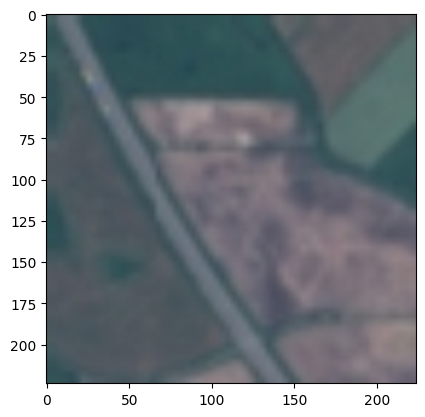

In [410]:
# Just checking for image visualization
images, labels = next(iter(train_data_loader))
plt.imshow(np.transpose(images[1], (1, 2, 0)))
print(labels[1].item())

In [4]:
# Download miniImageNet & EuroSAT(RGB)

# Split miniImageNet into training

# Pretrain a model
# ResNet10 / ResNet18 / VGG / Vision Transformer / etc

# Validate on validation set 

# Evaluate on test set

# Save pretrained model

# Choose 100 images from EuroSAT dataset
# 25 samples for 5 categories

# Randomly choose 25 images as training set
# 5 images for 5 categories

# Fine-tune the pretrained model

# Test model on the rest 75 samples
# Show results

# fine-tuning several times on different 100 EuroSAT images

# Get their average result


### Compare the performance of different models (ResNet18, VGG, Vision Transformer, etc.), and investigate the different optimization strategies. (This part will be used as a bonus item, 2 points)

In [2]:
# Use other models
# ResNet10 / ResNet18 / VGG / Vision Transformer / etc

# Use different optimization strategies

# Compare the performance


### If it’s possible, you can evaluate on the other datasets such as CropDiseases, CUB, ISIC, ChestX, etc. (This part will be used as a bonus item, 2 points)

In [3]:
# Evaluate on other datasets
# CropDiseases / CUB / ISIC / ChestX / etc
